In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import numpy as np
import json

from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

sns.set_style('whitegrid')
%matplotlib inline

/Users/RZB/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
with open('tweets.txt', 'r') as tweets_text:
    tweets_data = []
    for line in tweets_text:
        try:
            tweet = json.loads(line)
            if tweet['text'] is not None:
                tweets_data.append(tweet)
            else:
                print 'Caught'
        except:
            continue

In [3]:
print len(tweets_data)

16711


In [4]:
tweets_df = pd.DataFrame()
tweets_df['text'] = map(lambda tweet: tweet.get('text'), tweets_data)
tweets_df['lang'] = map(lambda tweet: tweet.get('lang',None).encode('utf-8'), tweets_data)
tweets_df['created_at'] = map(lambda tweet: tweet.get('created_at',None), tweets_data)
tweets_df['coordinates'] = map(lambda tweet: tweet.get('coordinates','None'), tweets_data)

def time_parser(df):
    new_time = df['created_at'].split('Dec 29 ')[1].split(' +')[0].replace(':', '')
    if int(new_time) <= 204600:
        time_class = 'Half time'
    elif 204600 <= int(new_time) <= 213500:
        time_class = 'Second half'
    else:
        time_class = 'Full time'

    return time_class 

tweets_df['parsed_time'] = tweets_df.apply(time_parser, axis = 1)

locations = []
for tweet in tweets_data:
    try:
        if tweet['user']:
            locations.append(tweet['user']['location'])
        else:
            locations.append('')
    except KeyError:
        locations.append('')
        continue

countries = []
for tweet in tweets_data:
    try:
        if tweet['place']:
            try:
                countries.append(tweet['place']['country'].encode('unicode_escape'))
            except AttributeError:
                continue
        else:
            countries.append('')
    except KeyError:
        countries.append('')
        continue
        

followers = []
for tweet in tweets_data:
    try:
        if tweet['user']:
            followers.append(tweet['user']['followers_count'])
        else:
            locations.append('')
    except KeyError:
        followers.append('')
        continue

username = []
for tweet in tweets_data:
    try:
        if tweet['user']:
            username.append(tweet['user']['screen_name'])
        else:
            username.append('')
    except KeyError:
        username.append('')
        continue
        
print len(followers)  
print len(username)
print len(countries)
print len(tweets_df)
print len(tweets_df['coordinates'].dropna())


16711
16711
16711
16711
27


In [5]:
tweets_df['username'] = username
tweets_df['country'] = countries
tweets_df['locations'] = locations
tweets_df['followers_count'] = followers
tweets_df.tail()

,text,lang,created_at,coordinates,parsed_time,username,country,locations,followers_count
16706,Leicester City 0-0 Manchester City: Foxes ente...,en,Tue Dec 29 21:46:02 +0000 2015,None,Full time,FIFAupdates,,Global,1321
16707,MAN CITY NEWS: Stats: Leicester City v Manches...,en,Tue Dec 29 21:46:02 +0000 2015,None,Full time,EPLNewsFeed,,None,266
16708,RT @OptaJoe: 1 - Manchester City have kept the...,en,Tue Dec 29 21:46:02 +0000 2015,None,Full time,BilboTeabaggin,,None,54
16709,RT @OptaJoe: 1 - Manchester City have kept the...,en,Tue Dec 29 21:46:02 +0000 2015,None,Full time,Dildeep96,,None,2300
16710,Belum Ada Gol di Laga Leicester vs City https:...,in,Tue Dec 29 21:46:02 +0000 2015,None,Full time,Muh_Haikal11,,kota palu,940


In [6]:
lang_count = tweets_df['lang'].value_counts()
l_df = pd.DataFrame(lang_count, columns = ['count'])[0:5]
l_df

,count
en,10742
es,1570
in,1501
fr,962
pt,517


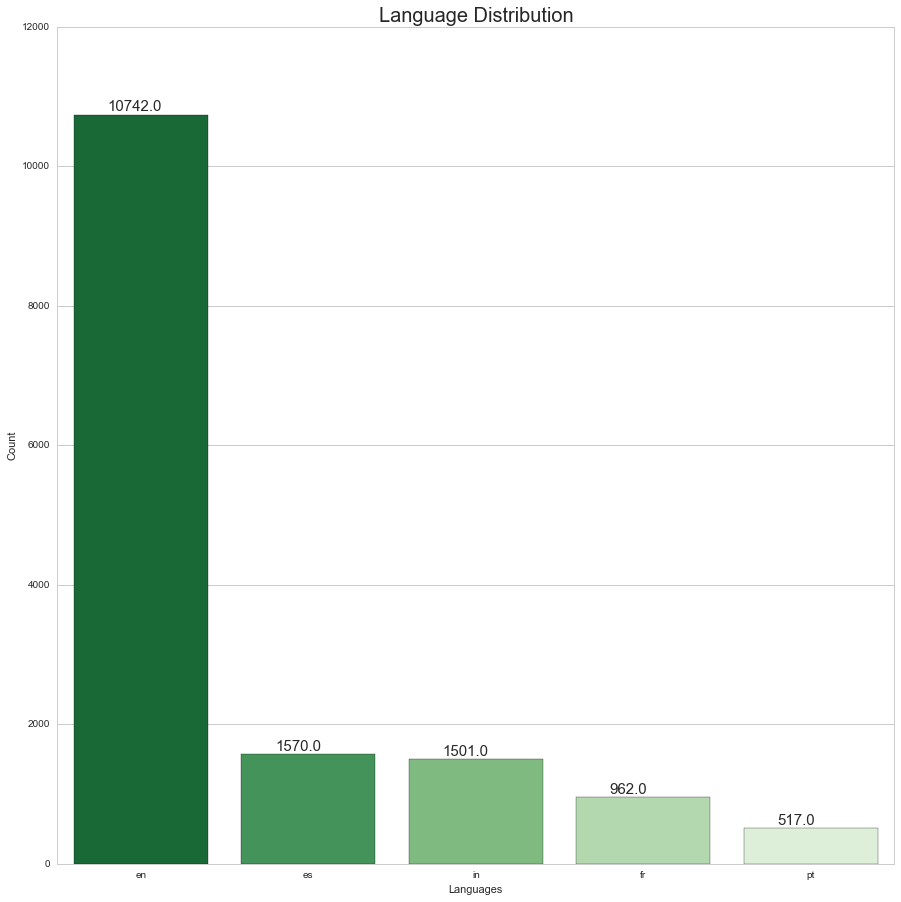

In [7]:

plt.figure(figsize = (15,15))
plt.title('Language Distribution', size = 20)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
langplt = sns.countplot(x = 'lang', palette= 'Greens_r', data = tweets_df, order=['en','es','in','fr','pt'])
plt.xlabel('Languages')
plt.ylabel('Count')

for p in langplt.patches:
        langplt.annotate(p.get_height(), (p.get_x() + 0.2, p.get_height() + 50), size = 15)


In [8]:
cnty_count = tweets_df['country'].value_counts()
c_df = pd.DataFrame(cnty_count, columns = ['count'])[1:10]
top10 = c_df.index
print top10

Index([u'United Kingdom', u'United States', u'Brasil', u'South Africa',
       u'Nigeria', u'France', u'Argentina', u'Espa\xf1a', u'Indonesia'],
      dtype='object')


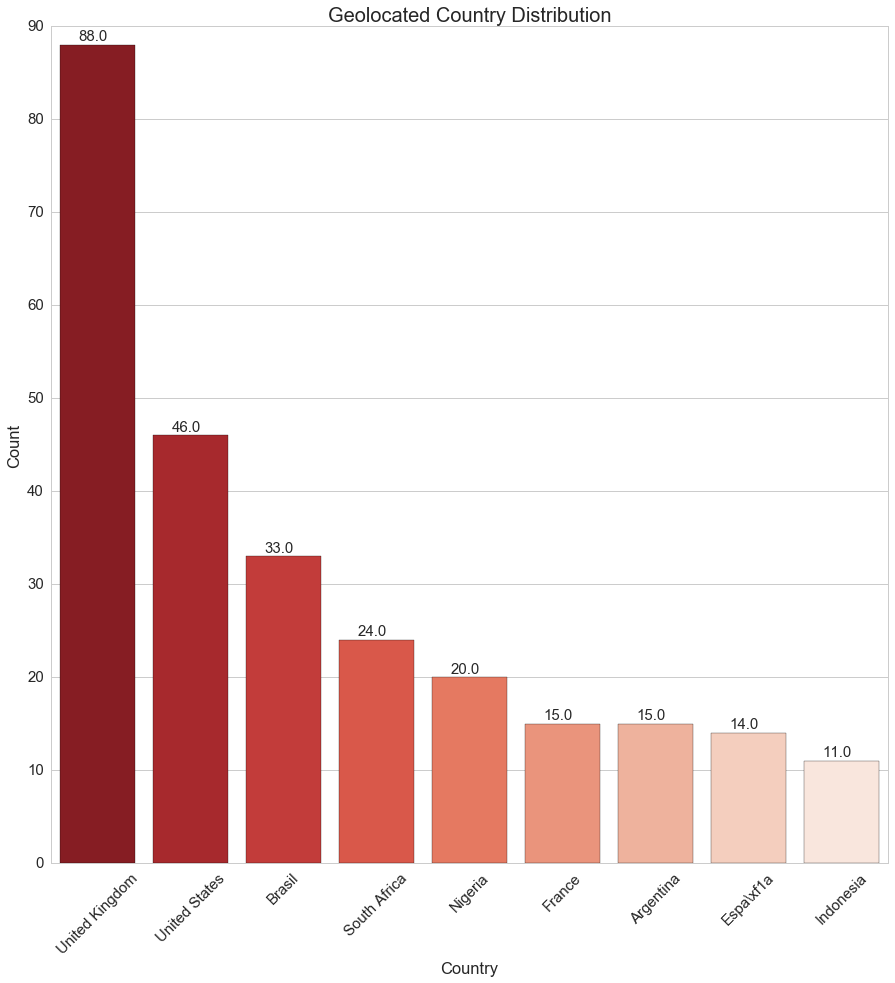

In [9]:
plt.figure(figsize = (15,15))
plt.title('Geolocated Country Distribution', size = 20)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
cntplot = sns.countplot(x = 'country', palette= 'Reds_r', data = tweets_df,order= top10)
for item in cntplot.get_xticklabels():
    item.set_rotation(45)
plt.xlabel('Country')
plt.ylabel('Count')
for p in cntplot.patches:
        cntplot.annotate(p.get_height(), (p.get_x()+0.2, p.get_height()+ 0.5), size = 15)

In [10]:
user_loc = tweets_df['locations'].value_counts()
loc_df = pd.DataFrame(user_loc, columns = ['count'])[0:10]
top10 = loc_df.index[0:10]
print top10


Index([      u'Indonesia',          u'London',         u'Nigeria',
        u'Lagos, Nigeria',      u'Manchester',           u'Lagos',
       u'London, England',  u'United Kingdom',  u'Nairobi, Kenya',
                    u'UK'],
      dtype='object')


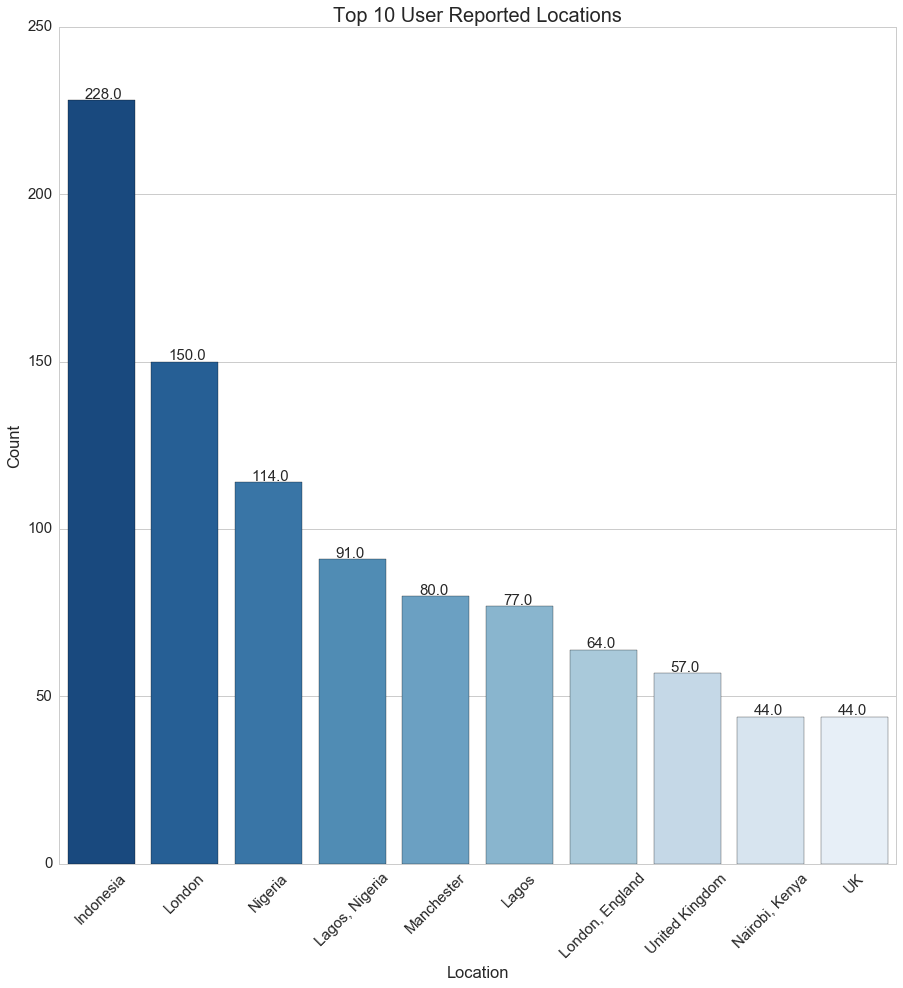

In [11]:
plt.figure(figsize = (15,15))
plt.title('Top 10 User Reported Locations', size = 20)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
usrlocplot = sns.countplot(x = 'locations', palette= 'Blues_r',data = tweets_df, order= top10)
plt.xlabel('Location')
plt.ylabel('Count')
for item in usrlocplot.get_xticklabels():
    item.set_rotation(45)

for p in usrlocplot.patches:
        usrlocplot.annotate(p.get_height(), (p.get_x()+0.2, p.get_height()+ 0.5), size = 15)

In [12]:
team_class = []
mcfc = []
lcfc = []

iterd = tweets_df.iterrows()
for t in iterd:
    try:
        if 'man' in t[1][0].lower() and 'leicester' not in t[1][0].lower() and t[1][1] == 'en':
            team_class.append('MCFC')
            mcfc.append('MCFC')
        elif 'leicester' in t[1][0].lower() and 'man' not in t[1][0].lower() and t[1][1] == 'en':
            team_class.append('LCFC')
            lcfc.append('LCFC')
        else:
            team_class.append('N/A')
    except AttributeError:
        print 'Caught'
        
tweets_df['team_class'] = team_class
        
print len(team_class)
print len(mcfc)
print len(lcfc)
tweets_df.head()

16711
1037
2977


,text,lang,created_at,coordinates,parsed_time,username,country,locations,followers_count,team_class
0,RT @FutballTweets: Leicester City's groundsman...,en,Tue Dec 29 20:44:53 +0000 2015,None,Half time,Qazeee_16,,Westside,411,N/A
1,RT @Footy_Jokes: Leicester City's groundsman d...,en,Tue Dec 29 20:44:52 +0000 2015,None,Half time,DominickC9,,None,270,N/A
2,RT @Footy_Jokes: Leicester City's groundsman d...,en,Tue Dec 29 20:44:53 +0000 2015,None,Half time,_Mayorwah,,None,178,N/A
3,HT: Leicester City 0 Manchester City. Sterling...,en,Tue Dec 29 20:44:53 +0000 2015,None,Half time,IndyFootball,,United Kingdom,47666,N/A
4,RT @ChefPhly: If Leicester City was in beMobil...,en,Tue Dec 29 20:44:54 +0000 2015,None,Half time,OaitseBW,,ENTER YOUR LOCATION,7263,LCFC


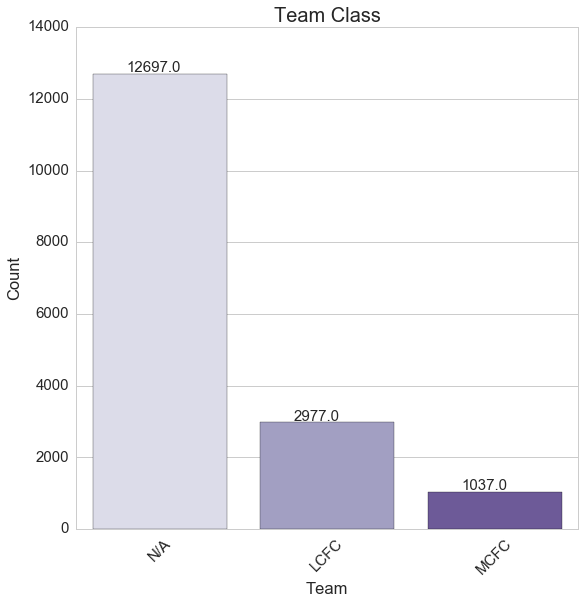

In [13]:
plt.figure(figsize = (9,9))
plt.title('Team Class', size = 20)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
tclassplot = sns.countplot(x = 'team_class', palette= 'Purples',data = tweets_df)
plt.xlabel('Team')
plt.ylabel('Count')
for item in tclassplot.get_xticklabels():
    item.set_rotation(45)

for p in tclassplot.patches:
        tclassplot.annotate(p.get_height(), (p.get_x()+0.2, p.get_height()+ 50), size = 15)

In [14]:
def tweet_cleaner(df):
    text = df['text'].lower().encode('unicode_escape')
    new_tweet = " ".join([word for word in text.split()
                            if 'http' not in word and '\u' not in word and '\U' not in word and "\n" not in word 
                                and not word.startswith('"@')
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and not word.startswith('\U')
                                and not word.startswith('\n')
                                and word != 'rt'
                                and word != '&amp;'
                            ])
    return new_tweet



In [15]:
tweets_df['cleaned_tweet'] = tweets_df.apply(tweet_cleaner, axis = 1)

In [16]:
tweets_df.tail()

,text,lang,created_at,coordinates,parsed_time,username,country,locations,followers_count,team_class,cleaned_tweet
16706,Leicester City 0-0 Manchester City: Foxes ente...,en,Tue Dec 29 21:46:02 +0000 2015,None,Full time,FIFAupdates,,Global,1321,N/A,leicester city 0-0 manchester city: foxes ente...
16707,MAN CITY NEWS: Stats: Leicester City v Manches...,en,Tue Dec 29 21:46:02 +0000 2015,None,Full time,EPLNewsFeed,,None,266,N/A,man city news: stats: leicester city v manches...
16708,RT @OptaJoe: 1 - Manchester City have kept the...,en,Tue Dec 29 21:46:02 +0000 2015,None,Full time,BilboTeabaggin,,None,54,MCFC,1 - manchester city have kept their first clea...
16709,RT @OptaJoe: 1 - Manchester City have kept the...,en,Tue Dec 29 21:46:02 +0000 2015,None,Full time,Dildeep96,,None,2300,MCFC,1 - manchester city have kept their first clea...
16710,Belum Ada Gol di Laga Leicester vs City https:...,in,Tue Dec 29 21:46:02 +0000 2015,None,Full time,Muh_Haikal11,,kota palu,940,N/A,belum ada gol di laga leicester vs city


In [17]:
pre_sent_df = tweets_df[['lang', 'cleaned_tweet']]
pre_sent_df.to_csv('sentiment.csv')
pre_sent_df.head()

,lang,cleaned_tweet
0,en,leicester city's groundsman deserve a medal
1,en,leicester city's groundsman deserve a medal
2,en,leicester city's groundsman deserve a medal
3,en,ht: leicester city 0 manchester city. sterling...
4,en,if leicester city was in bemobile league ne go...


In [18]:
sentiment_df = pd.read_csv('sentiment_scores.csv')
sent_col = sentiment_df['sent_score']
sent_col
frames = [tweets_df, sent_col]

tweets_df = pd.concat(frames, axis = 1)
tweets_df.head()

,text,lang,created_at,coordinates,parsed_time,username,country,locations,followers_count,team_class,cleaned_tweet,sent_score
0,RT @FutballTweets: Leicester City's groundsman...,en,Tue Dec 29 20:44:53 +0000 2015,None,Half time,Qazeee_16,,Westside,411,N/A,leicester city's groundsman deserve a medal,0.66
1,RT @Footy_Jokes: Leicester City's groundsman d...,en,Tue Dec 29 20:44:52 +0000 2015,None,Half time,DominickC9,,None,270,N/A,leicester city's groundsman deserve a medal,0.66
2,RT @Footy_Jokes: Leicester City's groundsman d...,en,Tue Dec 29 20:44:53 +0000 2015,None,Half time,_Mayorwah,,None,178,N/A,leicester city's groundsman deserve a medal,0.66
3,HT: Leicester City 0 Manchester City. Sterling...,en,Tue Dec 29 20:44:53 +0000 2015,None,Half time,IndyFootball,,United Kingdom,47666,N/A,ht: leicester city 0 manchester city. sterling...,0.19
4,RT @ChefPhly: If Leicester City was in beMobil...,en,Tue Dec 29 20:44:54 +0000 2015,None,Half time,OaitseBW,,ENTER YOUR LOCATION,7263,LCFC,if leicester city was in bemobile league ne go...,0.47


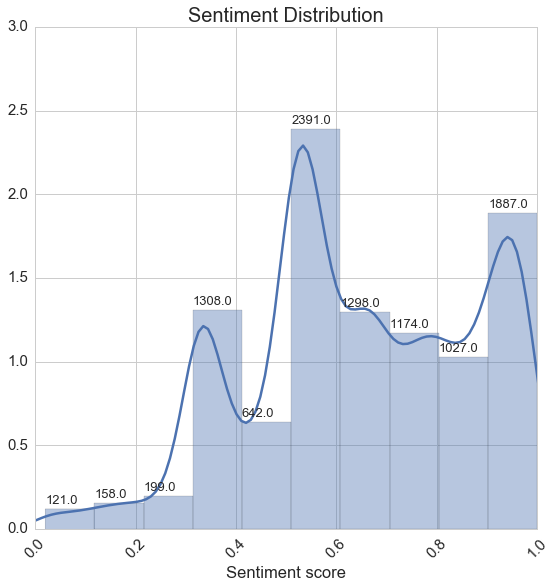

In [19]:
plt.figure(figsize = (9,9))
plt.title('Sentiment Distribution', size = 20)
sent_distplot = sns.distplot(tweets_df.sent_score.dropna(), bins = 10)
plt.xlim([0, 1])
plt.ylim([0,3])
plt.xlabel('Sentiment score')
for item in sent_distplot.get_xticklabels():
    item.set_rotation(45)

for p in sent_distplot.patches:
        sent_distplot.annotate(round(p.get_height()*1000), (p.get_x(), p.get_height()+ .03), size = 13)

/Users/RZB/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


(0, 1)

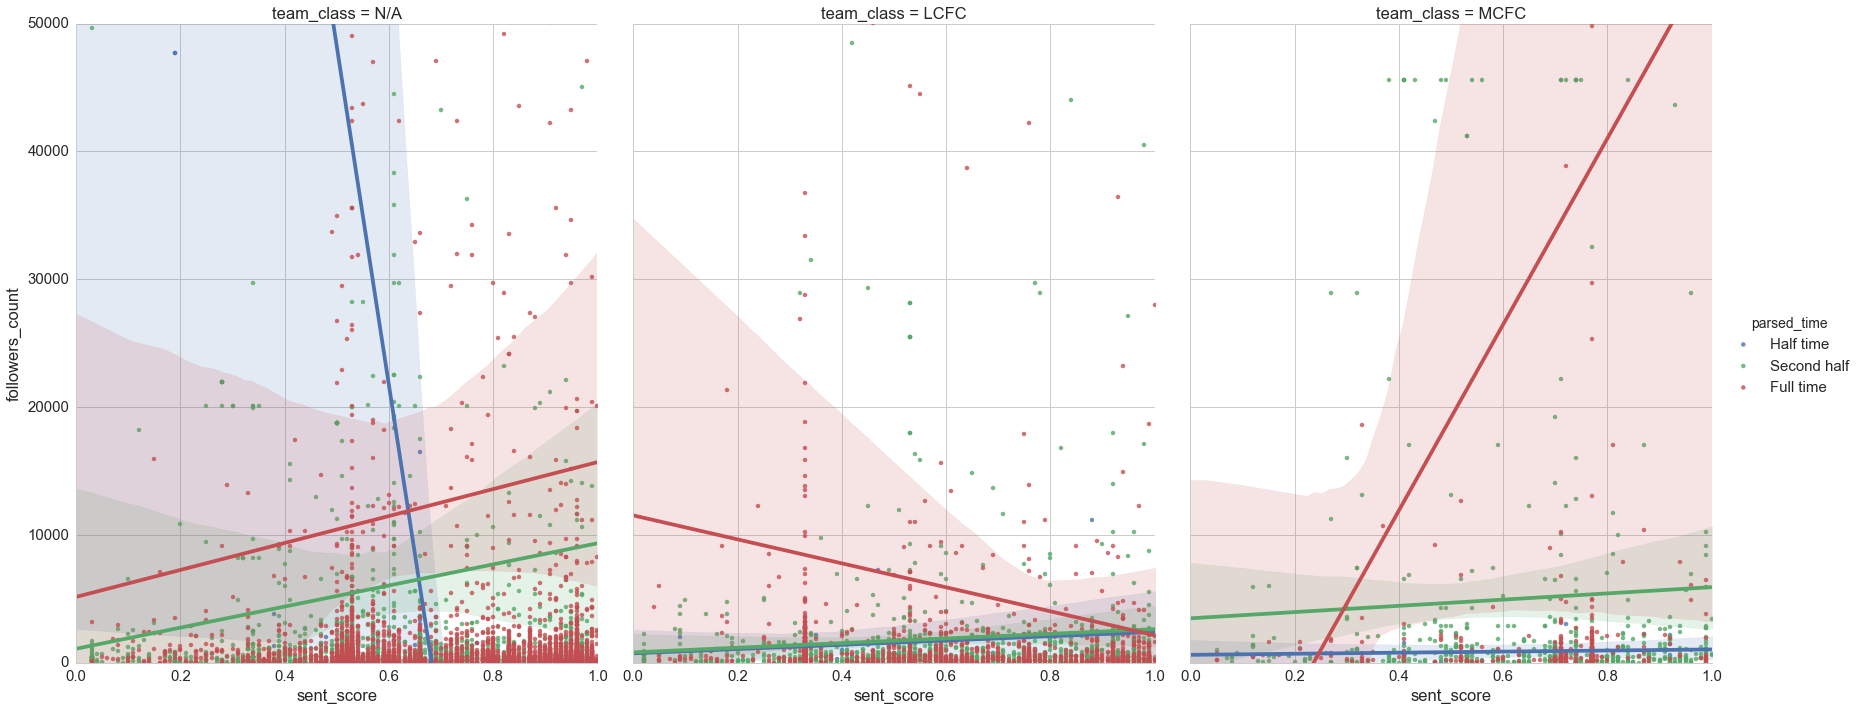

In [20]:
sentfol_plot = sns.lmplot(x = 'sent_score', y = 'followers_count', data = tweets_df,col= 'team_class', 
                          hue='parsed_time', size=10, aspect = .8)
plt.ylim([0,50000])
plt.xlim([0,1])

In [21]:
top_tweets = tweets_df['text'].value_counts()
top_tweets_df = pd.DataFrame(top_tweets, columns = ['count'])[0:10]
top10 = top_tweets_df.index[0:10]
top_tweets_df

,count
RT @rioferdy5: Leicester City seem disappointed with a point here...if Arsenal dont win the league this yr they need whipping with dry/hot …,757
RT @premierleague: FULL-TIME Leicester 0-0 Man City. #lcfc go level on points with #BPL leaders Arsenal after entertaining draw #LEIMCI htt…,484
RT @LCFC: Full-time: Leicester City 0-0 Manchester City #LeiMnc https://t.co/1SsFFgIMAA,236
RT @FootbalIStuff: Leicester City's groundsman deserve a medal 👌 https://t.co/bZWICg6l1J,187
RT @TrollFootball: LvG watching Leicester City vs Man City https://t.co/Ppa1nmCCC5,181
RT @OptaJoe: 1 - Manchester City have kept their first clean sheet of the season without Vincent Kompany in the line up. Zip.,164
RT @Footy_Jokes: Leicester City's groundsman deserve a medal 👌 https://t.co/8E6QXAQDRl,161
RT @JPW_NBCSports: Reminder that Leicester's starting XI cost $32.5 million &amp; Man City's cost $473 million. No real difference on this show…,157
RT @Footy_Jokes: FULL TIME: Leicester City 0-0 Manchester City \n\nLouis van Gaal's Philosophy! https://t.co/9CJoRqPvmB,127
"RT @ActuFoot_: 🕘 TERMINE !\n\nLeicester 0-0 Man. City\n\nLeicester redescend 2ème derrière Arsenal, Manchester City est 3ème !\nhttps://t.co/n…",110


In [22]:
iterrer = tweets_df.iterrows()
rt = []
rt_count = []
for t in iterrer:
    if t[1][0].startswith('RT'):
        rt.append('Y')
        rt_count.append('rt')
    else:
        rt.append('N')
print len(rt_count)



7813


In [23]:
tweets_df['RT_binary'] = rt
tweets_df.head()

,text,lang,created_at,coordinates,parsed_time,username,country,locations,followers_count,team_class,cleaned_tweet,sent_score,RT_binary
0,RT @FutballTweets: Leicester City's groundsman...,en,Tue Dec 29 20:44:53 +0000 2015,None,Half time,Qazeee_16,,Westside,411,N/A,leicester city's groundsman deserve a medal,0.66,Y
1,RT @Footy_Jokes: Leicester City's groundsman d...,en,Tue Dec 29 20:44:52 +0000 2015,None,Half time,DominickC9,,None,270,N/A,leicester city's groundsman deserve a medal,0.66,Y
2,RT @Footy_Jokes: Leicester City's groundsman d...,en,Tue Dec 29 20:44:53 +0000 2015,None,Half time,_Mayorwah,,None,178,N/A,leicester city's groundsman deserve a medal,0.66,Y
3,HT: Leicester City 0 Manchester City. Sterling...,en,Tue Dec 29 20:44:53 +0000 2015,None,Half time,IndyFootball,,United Kingdom,47666,N/A,ht: leicester city 0 manchester city. sterling...,0.19,N
4,RT @ChefPhly: If Leicester City was in beMobil...,en,Tue Dec 29 20:44:54 +0000 2015,None,Half time,OaitseBW,,ENTER YOUR LOCATION,7263,LCFC,if leicester city was in bemobile league ne go...,0.47,Y


In [24]:
tweets_df_nort = tweets_df[(tweets_df.RT_binary == 'N')] 
tweets_df_nort.head()

,text,lang,created_at,coordinates,parsed_time,username,country,locations,followers_count,team_class,cleaned_tweet,sent_score,RT_binary
3,HT: Leicester City 0 Manchester City. Sterling...,en,Tue Dec 29 20:44:53 +0000 2015,None,Half time,IndyFootball,,United Kingdom,47666,N/A,ht: leicester city 0 manchester city. sterling...,0.19,N
5,WATCH LIVE STREAM ONLINE\n\nLeicester 0 - 0 Ma...,en,Tue Dec 29 20:44:55 +0000 2015,None,Half time,Live_Sokker,,None,3807,N/A,watch live stream online\n\nleicester 0 - 0 ma...,0.38,N
9,#LEIMCI Check our forecasts for the match betw...,en,Tue Dec 29 20:44:57 +0000 2015,None,Half time,AIBetEU,,None,54,N/A,check our forecasts for the match between leic...,0.87,N
10,Definitely 🔥🔥 https://t.co/4GRVhRnCOa,en,Tue Dec 29 20:44:58 +0000 2015,None,Half time,Thabi_TopDecks,South Africa,PTA,1361,N/A,definitely,0.65,N
16,"Premier League, Leicester-Manchester City 0-0 ...",fr,Tue Dec 29 20:44:59 +0000 2015,None,Half time,Calciomercato_O,,"Udine, Friuli-Venezia Giulia",38,N/A,"premier league, leicester-manchester city 0-0 ...",NaN,N


(0, 1)

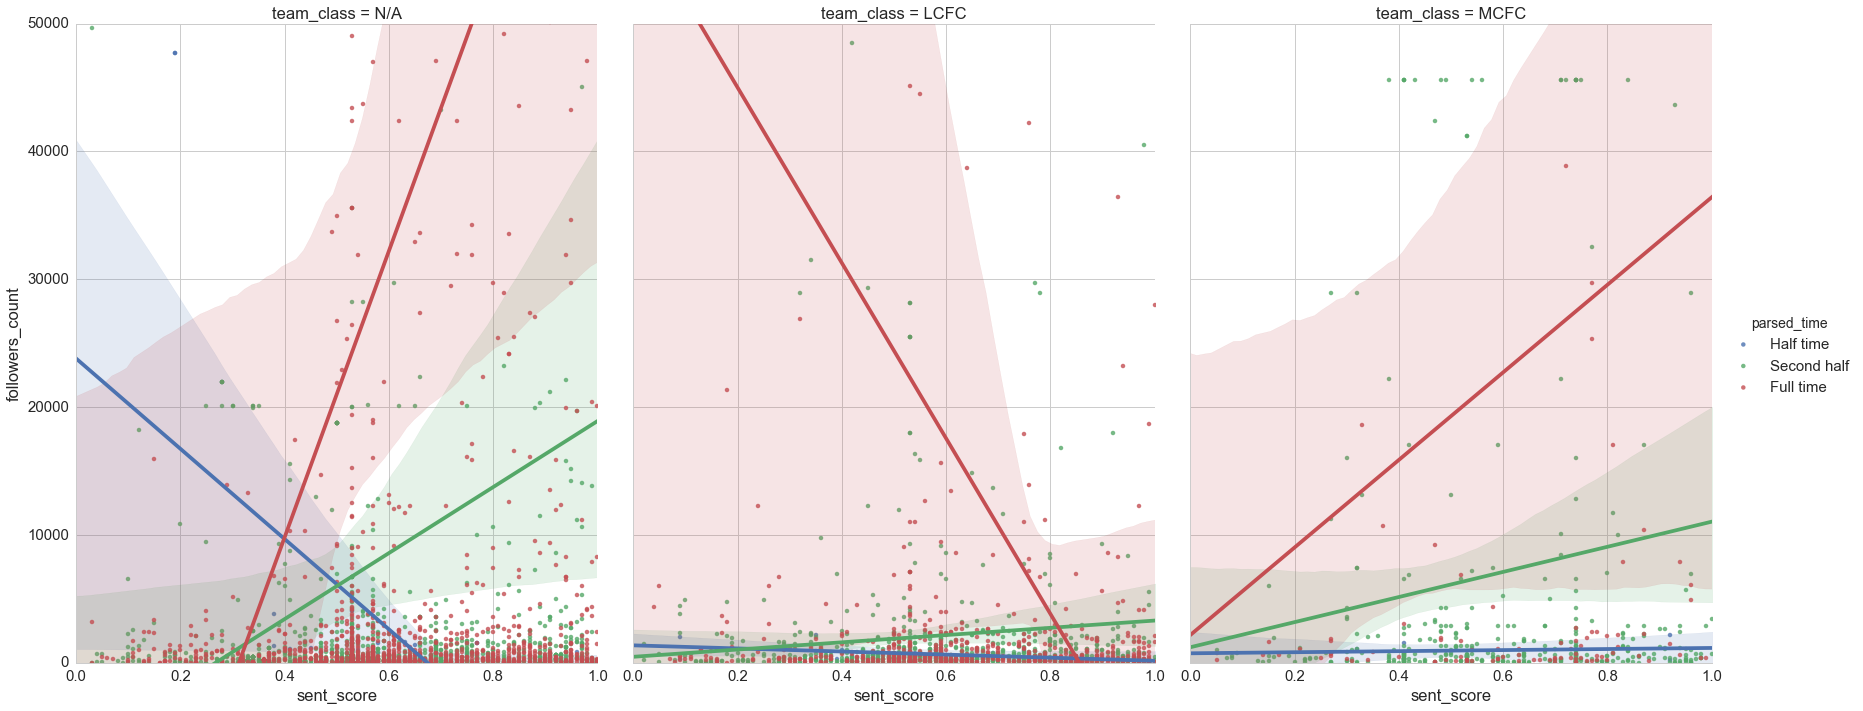

In [25]:
sentfol_plot_nort = sns.lmplot(x = 'sent_score', y = 'followers_count', data = tweets_df_nort,col= 'team_class', 
                          hue='parsed_time', size=10, aspect = .8)
plt.ylim([0,50000])
plt.xlim([0,1])

In [26]:
print 'Mean sentiment score = ' + str(tweets_df_nort.sent_score.mean())
print 'Mean sentiment score without retweets = ' + str(tweets_df.sent_score.mean())

Mean sentiment score = 0.602633719748
Mean sentiment score without retweets = 0.642631725936


In [27]:
def sent_class_assign(df):
    p_pos = df['sent_score']
    if p_pos <= .20:
        sent_class = 'Very Negative'
    elif .20 < p_pos <= .40:
        sent_class = 'Negative'
    elif .40 < p_pos <= .60:
        sent_class = 'Neutral'
    elif .60 < p_pos <= .80:
        sent_class = 'Positive'
    elif .80 < p_pos <= 1.0:
        sent_class = 'Very Positive'
    else:
        sent_class = ''
    return sent_class
            
tweets_df['sent_class'] = tweets_df.apply(sent_class_assign, axis = 1)
tweets_df_nort['sent_class'] = tweets_df_nort.apply(sent_class_assign, axis = 1)

tweets_df_nort

/Users/RZB/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,text,lang,created_at,coordinates,parsed_time,username,country,locations,followers_count,team_class,cleaned_tweet,sent_score,RT_binary,sent_class
3,HT: Leicester City 0 Manchester City. Sterling...,en,Tue Dec 29 20:44:53 +0000 2015,None,Half time,IndyFootball,,United Kingdom,47666,N/A,ht: leicester city 0 manchester city. sterling...,0.19,N,Very Negative
5,WATCH LIVE STREAM ONLINE\n\nLeicester 0 - 0 Ma...,en,Tue Dec 29 20:44:55 +0000 2015,None,Half time,Live_Sokker,,None,3807,N/A,watch live stream online\n\nleicester 0 - 0 ma...,0.38,N,Negative
9,#LEIMCI Check our forecasts for the match betw...,en,Tue Dec 29 20:44:57 +0000 2015,None,Half time,AIBetEU,,None,54,N/A,check our forecasts for the match between leic...,0.87,N,Very Positive
10,Definitely 🔥🔥 https://t.co/4GRVhRnCOa,en,Tue Dec 29 20:44:58 +0000 2015,None,Half time,Thabi_TopDecks,South Africa,PTA,1361,N/A,definitely,0.65,N,Positive
16,"Premier League, Leicester-Manchester City 0-0 ...",fr,Tue Dec 29 20:44:59 +0000 2015,None,Half time,Calciomercato_O,,"Udine, Friuli-Venezia Giulia",38,N/A,"premier league, leicester-manchester city 0-0 ...",NaN,N,
17,Partidazo entre Leicester City vs Man City 🔥�...,es,Tue Dec 29 20:45:00 +0000 2015,None,Half time,dpablo94,,"Acacias, Madrid",429,N/A,partidazo entre leicester city vs man city,NaN,N,
20,Leicester City - Man City #live\nWhat is the r...,en,Tue Dec 29 20:45:01 +0000 2015,None,Half time,BetAngel1x2,,Las Vegas,1273,N/A,leicester city - man city is the result after ...,0.38,N,Negative
22,You just know Leicester are going to nick it �...,en,Tue Dec 29 20:45:01 +0000 2015,None,Half time,Padge1189,,loughborough,275,LCFC,you just know leicester are going to nick it,0.39,N,Negative
25,Leicester 0-0 Man City Second Half,en,Tue Dec 29 20:45:02 +0000 2015,None,Half time,suttyant,,Farnworth.Bolton,25,N/A,leicester 0-0 man city second half,0.51,N,Neutral
28,"City should have won this league the easy way,...",en,Tue Dec 29 20:45:03 +0000 2015,None,Half time,UtdDi,,None,2192,LCFC,"city should have won this league the easy way,...",0.35,N,Negative


(0, 1)

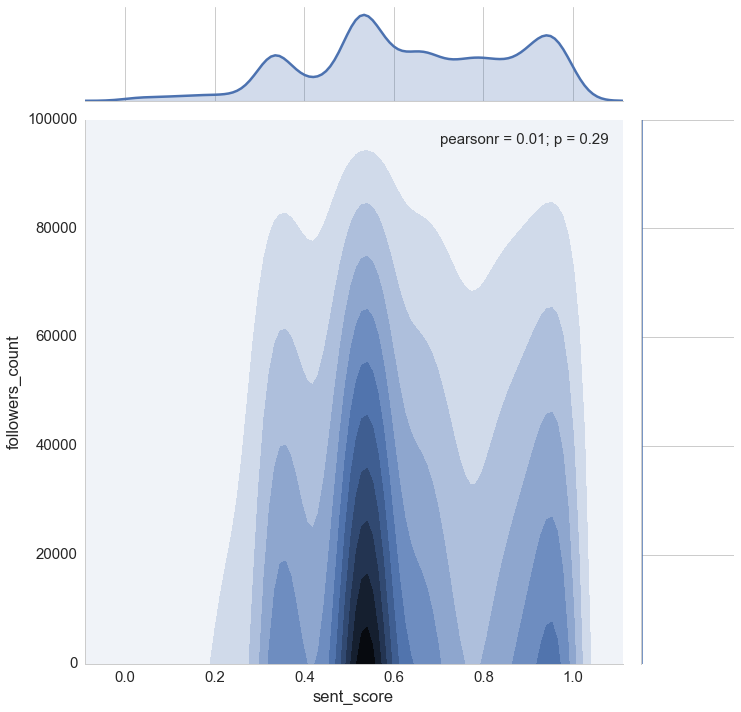

In [28]:

sns.jointplot(x = 'sent_score', y = 'followers_count', data = tweets_df, kind = 'kde',size = 10)
plt.ylim([0,100000])
plt.xlim([0,1])



In [29]:
print tweets_df['sent_score'].mean()
tweets_df['count'] = 1
tweets_df_nort['count'] = 1
tweets_df.head()

0.642631725936


/Users/RZB/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,text,lang,created_at,coordinates,parsed_time,username,country,locations,followers_count,team_class,cleaned_tweet,sent_score,RT_binary,sent_class,count
0,RT @FutballTweets: Leicester City's groundsman...,en,Tue Dec 29 20:44:53 +0000 2015,None,Half time,Qazeee_16,,Westside,411,N/A,leicester city's groundsman deserve a medal,0.66,Y,Positive,1
1,RT @Footy_Jokes: Leicester City's groundsman d...,en,Tue Dec 29 20:44:52 +0000 2015,None,Half time,DominickC9,,None,270,N/A,leicester city's groundsman deserve a medal,0.66,Y,Positive,1
2,RT @Footy_Jokes: Leicester City's groundsman d...,en,Tue Dec 29 20:44:53 +0000 2015,None,Half time,_Mayorwah,,None,178,N/A,leicester city's groundsman deserve a medal,0.66,Y,Positive,1
3,HT: Leicester City 0 Manchester City. Sterling...,en,Tue Dec 29 20:44:53 +0000 2015,None,Half time,IndyFootball,,United Kingdom,47666,N/A,ht: leicester city 0 manchester city. sterling...,0.19,N,Very Negative,1
4,RT @ChefPhly: If Leicester City was in beMobil...,en,Tue Dec 29 20:44:54 +0000 2015,None,Half time,OaitseBW,,ENTER YOUR LOCATION,7263,LCFC,if leicester city was in bemobile league ne go...,0.47,Y,Neutral,1


In [30]:
hm_df = tweets_df_nort[tweets_df_nort.sent_class != '']
nahm_df = hm_df[hm_df.team_class == 'N/A']

team_df = hm_df[hm_df.team_class != 'N/A']
lchm_df = team_df[team_df.team_class != 'MCFC']
mchm_df = team_df[team_df.team_class != 'LCFC']


nahm_pivot = nahm_df.pivot_table('count',
                                index='sent_class',
                                columns='parsed_time', aggfunc='sum')
lchm_pivot = lchm_df.pivot_table('count',
                                index= 'sent_class',
                                columns='parsed_time', aggfunc='sum')
mchm_pivot = mchm_df.pivot_table('count',
                                index='sent_class',
                                columns='parsed_time', aggfunc='sum')




nahm_pivot

parsed_time,Full time,Half time,Second half
sent_class,,,
Negative,105,4,244
Neutral,502,22,819
Positive,306,12,288
Very Negative,38,2,42
Very Positive,277,4,266


In [31]:
mchm_avg_sent_second = mchm_df[mchm_df.parsed_time == 'Second half']
mchm_avg_sent_half = mchm_df[mchm_df.parsed_time == 'Half time']
mchm_avg_sent_full = mchm_df[mchm_df.parsed_time == 'Full time']

lchm_avg_sent_second = lchm_df[lchm_df.parsed_time == 'Second half']
lchm_avg_sent_half = lchm_df[lchm_df.parsed_time == 'Half time']
lchm_avg_sent_full = lchm_df[lchm_df.parsed_time == 'Full time']

nahm_avg_sent_second = nahm_df[nahm_df.parsed_time == 'Second half']
nahm_avg_sent_half = nahm_df[nahm_df.parsed_time == 'Half time']
nahm_avg_sent_full = nahm_df[nahm_df.parsed_time == 'Full time']

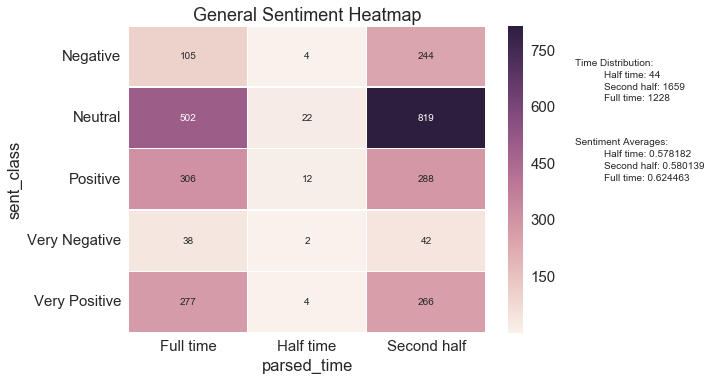

In [32]:
plt.title('General Sentiment Heatmap')
#plt.figure(figsize= (11,11))
sns.heatmap(nahm_pivot, annot= True, fmt = '.9g', linewidths=.5)
plt.figtext(.9, 0.8, "Time Distribution:")
plt.figtext(.95, 0.77, "Half time: %i" % nahm_avg_sent_half.sent_score.count())
plt.figtext(.95, 0.74, "Second half: %i" % nahm_avg_sent_second.sent_score.count())
plt.figtext(.95, 0.71, "Full time: %i" % nahm_avg_sent_full.sent_score.count())
plt.figtext(.9, 0.6, "Sentiment Averages:")
plt.figtext(.95, 0.57, "Half time: %f" % nahm_avg_sent_half.sent_score.mean())
plt.figtext(.95, 0.54, "Second half: %f" % nahm_avg_sent_second.sent_score.mean())
plt.figtext(.95, 0.51, "Full time: %f" % nahm_avg_sent_full.sent_score.mean())

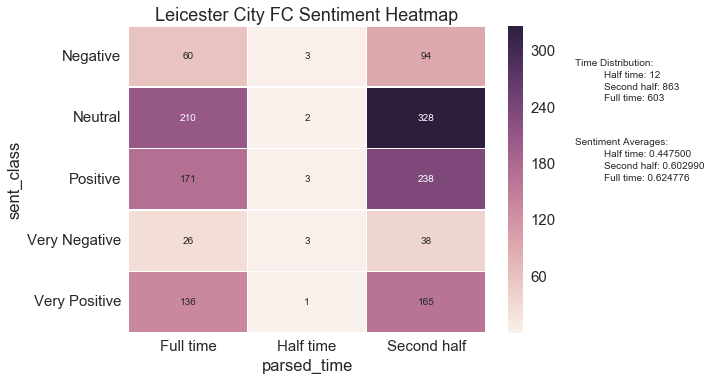

In [33]:
plt.title('Leicester City FC Sentiment Heatmap')
#plt.figure(figsize= (11,11))
sns.heatmap(lchm_pivot, annot= True, fmt = '.9g', linewidths=.5)
plt.figtext(.9, 0.8, "Time Distribution:")
plt.figtext(.95, 0.77, "Half time: %i" % lchm_avg_sent_half.sent_score.count())
plt.figtext(.95, 0.74, "Second half: %i" % lchm_avg_sent_second.sent_score.count())
plt.figtext(.95, 0.71, "Full time: %i" % lchm_avg_sent_full.sent_score.count())
plt.figtext(.9, 0.6, "Sentiment Averages:")
plt.figtext(.95, 0.57, "Half time: %f" % lchm_avg_sent_half.sent_score.mean())
plt.figtext(.95, 0.54, "Second half: %f" % lchm_avg_sent_second.sent_score.mean())
plt.figtext(.95, 0.51, "Full time: %f" % lchm_avg_sent_full.sent_score.mean())

parsed_time
Full time       97
Half time        6
Second half    405
dtype: float64


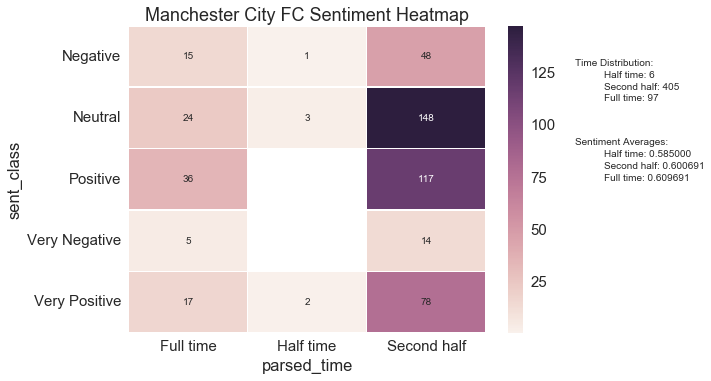

In [34]:
plt.title('Manchester City FC Sentiment Heatmap')
#plt.figure(figsize= (11,11))
sns.heatmap(mchm_pivot, annot= True, fmt = '.9g', linewidths=.5)
plt.figtext(.9, 0.8, "Time Distribution:")
plt.figtext(.95, 0.77, "Half time: %i" % mchm_avg_sent_half.sent_score.count())
plt.figtext(.95, 0.74, "Second half: %i" % mchm_avg_sent_second.sent_score.count())
plt.figtext(.95, 0.71, "Full time: %i" % mchm_avg_sent_full.sent_score.count())
plt.figtext(.9, 0.6, "Sentiment Averages:")
plt.figtext(.95, 0.57, "Half time: %f" % mchm_avg_sent_half.sent_score.mean())
plt.figtext(.95, 0.54, "Second half: %f" % mchm_avg_sent_second.sent_score.mean())
plt.figtext(.95, 0.51, "Full time: %f" % mchm_avg_sent_full.sent_score.mean())
print mchm_pivot.sum()

In [35]:
cord_df = tweets_df[tweets_df.coordinates != 'None'].dropna()


def lat_parse(df):
    lat = str(df['coordinates'])
    lat = lat.split("'coordinates': [")[1].split(']')[0]
    lat = lat.split(',')[0]
    return lat

def lon_parse(df):
    lon = str(df['coordinates'])
    lon = lon.split("'coordinates': [")[1].split(']')[0]
    lon = lon.split(',')[1]
    return lon

cord_df['lat'] = cord_df.apply(lat_parse, axis = 1)
cord_df['lon'] = cord_df.apply(lon_parse, axis = 1)
cord_df[['lat', 'lon']]

df = cord_df.iterrows()

for g in df:
    print g[1][15], g[1][16]

cord_df

28.896369  -11.2017177
2.3412  48.8569
36.89082045  -1.29284345
-0.2959486  51.3705322
-74.20032308  40.84992453
-95.5645981  29.7286091
30.6687566  -28.2046533
24.677  -28.4832
24.677  -28.4832
35.3106073  0.5495475
3.3625679  7.2128198
-0.2556993  5.62670864
-49.3372241  -24.1120196
-2.26667  53.4833
-1.14236355  52.62042873
-1.49858637  53.410044


,text,lang,created_at,coordinates,parsed_time,username,country,locations,followers_count,team_class,cleaned_tweet,sent_score,RT_binary,sent_class,count,lat,lon
646,Moment when u supporting Leicester City and u ...,en,Tue Dec 29 20:47:59 +0000 2015,"{u'type': u'Point', u'coordinates': [28.896369...",Second half,Chilu1Love,Zambia,"Kabwe, Mulungushi University.",57,N/A,moment when u supporting leicester city and u ...,0.59,N,Neutral,1,28.896369,-11.2017177
732,'Manchester City' just started trending with 3...,en,Tue Dec 29 20:48:21 +0000 2015,"{u'type': u'Point', u'coordinates': [2.3412, 4...",Second half,trendinaliaFR,France,France,1838,MCFC,'manchester city' just started trending with 3...,0.59,N,Neutral,1,2.3412,48.8569
2234,Leicester City are 20th in the league in Succe...,en,Tue Dec 29 20:57:39 +0000 2015,"{u'type': u'Point', u'coordinates': [36.890820...",Second half,IamGift254,Kenya,"Nairobi, Kenya",1650,LCFC,leicester city are 20th in the league in succe...,0.99,N,Very Positive,1,36.89082045,-1.29284345
3485,If Chelsea showed half the guts and endeavour ...,en,Tue Dec 29 21:03:38 +0000 2015,"{u'type': u'Point', u'coordinates': [-0.295948...",Second half,larusticapizza,United Kingdom,"Surrey, UK",73,LCFC,if chelsea showed half the guts and endeavour ...,0.51,N,Neutral,1,-0.2959486,51.3705322
3946,Watching Leicester take on Man City (@ Home in...,en,Tue Dec 29 21:06:08 +0000 2015,"{u'type': u'Point', u'coordinates': [-74.20032...",Second half,ritters90,United States,London,5712,N/A,watching leicester take on man city (@ home in...,0.57,N,Neutral,1,-74.20032308,40.84992453
3952,In the zone working and watching Leicester vs ...,en,Tue Dec 29 21:06:10 +0000 2015,"{u'type': u'Point', u'coordinates': [-95.56459...",Second half,JL_Rayo,United States,Houston,196,N/A,in the zone working and watching leicester vs ...,0.53,N,Neutral,1,-95.5645981,29.7286091
4168,Leicester city though..... This is true football,en,Tue Dec 29 21:07:22 +0000 2015,"{u'type': u'Point', u'coordinates': [30.668756...",Second half,Sebastian_Lethu,South Africa,ambitionville,352,LCFC,leicester city though..... this is true football,0.58,N,Neutral,1,30.6687566,-28.2046533
4962,Trend Alert: 'Manchester City'. More trends at...,en,Tue Dec 29 21:12:17 +0000 2015,"{u'type': u'Point', u'coordinates': [24.677, -...",Second half,trendinaliaZA,South Africa,South Africa,13090,MCFC,trend alert: 'manchester city'. more trends at,0.33,N,Negative,1,24.677,-28.4832
6111,1. #LEIMCI\n2. #Muvhango\n3. #Checkpoint\n4. M...,en,Tue Dec 29 21:20:37 +0000 2015,"{u'type': u'Point', u'coordinates': [24.677, -...",Second half,trendinaliaZA,South Africa,South Africa,13090,MCFC,1. manchester city\n5. 23:16 sast,0.50,N,Neutral,1,24.677,-28.4832
8491,FT Leicester 0 0 Man City.\nGooners 'Top of th...,en,Tue Dec 29 21:35:26 +0000 2015,"{u'type': u'Point', u'coordinates': [35.310607...",Full time,TheBryo,Kenya,Nairobi KENYA,8990,N/A,ft leicester 0 0 man city.\ngooners 'top of th...,0.53,N,Neutral,1,35.3106073,0.5495475


Mansa ,  Zambia
Paris ,  France
Nairobi ,  Kenya
Chessington ,  United Kingdom
Montclair ,  United States
Houston ,  United States
Ndindindi ,  South Africa
None ,  South Africa
None ,  South Africa
None ,  Kenya
None ,  Nigeria
None ,  None
None ,  None
None ,  None
Leicester ,  United Kingdom
Sheffield ,  United Kingdom


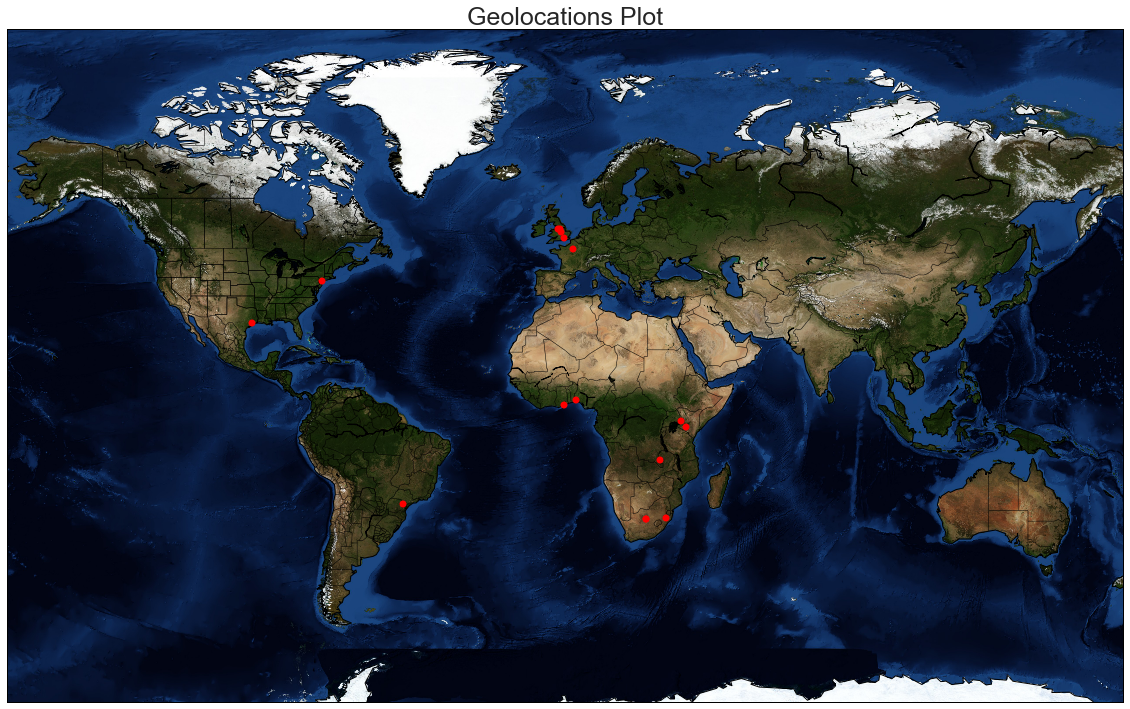

In [36]:
import geocoder
plt.figure(figsize=(20,20))

m = Basemap(projection='mill',llcrnrlat= -70,urcrnrlat=86,\
                llcrnrlon=-170,urcrnrlon=170,resolution='c')
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawmapboundary(fill_color='#FFFFFF')
m.bluemarble()

corditer = cord_df.iterrows()

re_geo_df = pd.DataFrame()
geo_cit = []
geo_cnty = []

for c in corditer:
    lat = float(c[1][15])
    lon = float(c[1][16])
    
    g = geocoder.google([lon, lat], method='reverse')
    print g.city,', ',g.country_long
    
    geo_cit.append(g.city)
    geo_cnty.append(g.country_long)
    
    xpt,ypt = m(lat,lon)
    m.plot(xpt,ypt, 'ro', markersize= 7)


plt.title("Geolocations Plot", size = 25)

plt.show()


In [37]:
re_geo_df['City'] = geo_cit
re_geo_df['Country'] = geo_cnty
re_geo_df

,City,Country
0,Mansa,Zambia
1,Paris,France
2,Nairobi,Kenya
3,Chessington,United Kingdom
4,Montclair,United States
5,Houston,United States
6,Ndindindi,South Africa
7,None,South Africa
8,None,South Africa
9,None,Kenya
